# Comparative Analysis of LSTM and Prophet Models for Stock Price Prediction
## Note 1

Long Short Term Memory and Prophet are two very popular models that are used in machine learning for prediction. The models have been celebrated for there performance in various quarters. In this project, we examine the performance of each of these models, using only the default arguments in each. The performance of these models are then compared to discover of them perform better under those conditions.

This portion of the notebook focuses on the LSTM model, the Prophet model is executed in a second notebook.

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline
from pandas import DataFrame
from pandas import to_datetime
import pandas_datareader as web
import datetime
from datetime import date, timedelta
from datetime import datetime
import yfinance as yf
from prophet import Prophet
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error

import warnings
warnings.filterwarnings('ignore')

C:\Users\Samuel Chika\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import seaborn as sb

Below, the duration for which the stock data will be capturewd is being specified. The decision was made to define a specific start and end date to ensure that whenever this code is reproduced, the same data is captured whcih then ensures the same results is gotten.

In [3]:
# Set the date range for stock data.

import datetime

s_date = datetime.date(2000,1,1)
e_date = datetime.date(2022,10,31)

In [4]:
# Download the stock data for META from Yahoo finance

apple_data = yf.download('AAPL', start = s_date, end = e_date, progress = False)

In [5]:
# Set the "Date" column as the index of the dataset

apple_data["Date"] = apple_data.index

In [6]:
# Inspect the first few rows in the dataset

apple_data.head()

,Open,High,Low,Close,Adj Close,Volume,Date
Date,,,,,,,
2000-01-03,0.936384,1.004464,0.907924,0.999442,0.851942,535796800,2000-01-03
2000-01-04,0.966518,0.987723,0.903460,0.915179,0.780115,512377600,2000-01-04
2000-01-05,0.926339,0.987165,0.919643,0.928571,0.791531,778321600,2000-01-05
2000-01-06,0.947545,0.955357,0.848214,0.848214,0.723033,767972800,2000-01-06
2000-01-07,0.861607,0.901786,0.852679,0.888393,0.757282,460734400,2000-01-07


In [7]:
# Get an overview of the properties of the dataset and its columns

apple_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5744 entries, 2000-01-03 to 2022-10-28
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Open       5744 non-null   float64       
 1   High       5744 non-null   float64       
 2   Low        5744 non-null   float64       
 3   Close      5744 non-null   float64       
 4   Adj Close  5744 non-null   float64       
 5   Volume     5744 non-null   int64         
 6   Date       5744 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 359.0 KB


In [8]:
# Rearrage the columns in the dataset

apple_data = apple_data[["Date", "Open", "High", "Low", "Close", "Adj Close", "Volume"]]
apple_data.reset_index(drop = True, inplace = True)
apple_data.tail(3)

,Date,Open,High,Low,Close,Adj Close,Volume
5741,2022-10-26,150.960007,151.990005,148.039993,149.350006,149.102661,88194300
5742,2022-10-27,148.070007,149.050003,144.130005,144.800003,144.560196,109180200
5743,2022-10-28,148.199997,157.500000,147.820007,155.740005,155.482086,164762400


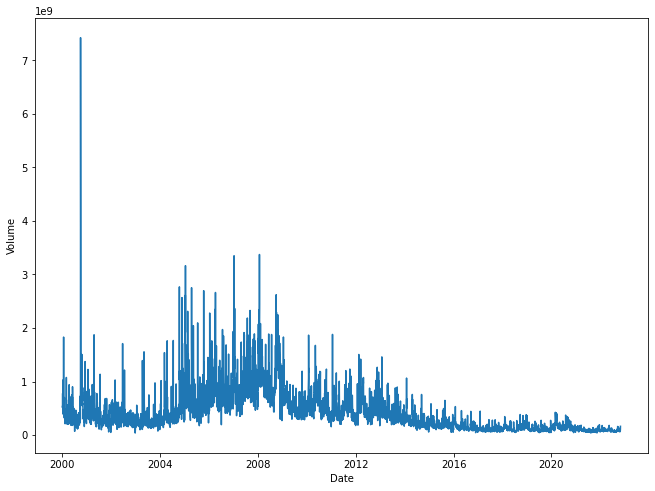

In [9]:
import seaborn as sb

# create line plot of sales data
plt.figure(figsize=[11, 8])
plt.plot(apple_data["Date"], apple_data["Volume"])
plt.xlabel("Date")
plt.ylabel("Volume")
plt.show()

In [10]:
# Insoect the statistical properties of the dataset

apple_data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5744.000000,5744.000000,5744.000000,5744.000000,5744.000000,5.744000e+03
mean,29.099760,29.428103,28.779173,29.116487,27.922384,4.168446e+08
std,42.182208,42.700514,41.691415,42.218036,42.052885,3.874615e+08
min,0.231964,0.235536,0.227143,0.234286,0.199710,3.934000e+07
25%,1.823482,1.850357,1.794643,1.827768,1.558022,1.445834e+08
50%,12.517500,12.637500,12.412143,12.522500,10.674404,3.009482e+08
75%,33.801251,33.961875,33.668749,33.847501,31.813537,5.530245e+08
max,182.630005,182.940002,179.119995,182.009995,180.959747,7.421641e+09


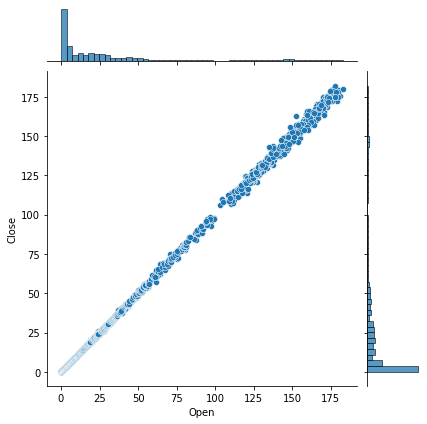

In [11]:
# Joint plot between the Open and Close values

sb.jointplot(x=apple_data['Open'], y=apple_data['Close'], data=apple_data, kind='scatter')

Close        1.000000
Low          0.999912
High         0.999910
Open         0.999810
Adj Close    0.999757
Volume      -0.426142
Name: Close, dtype: float64


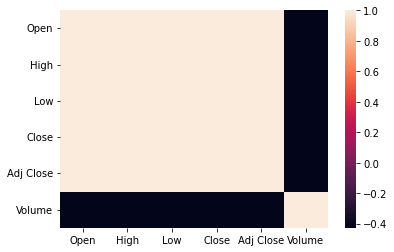

In [12]:
# Inspect the correlation of the variables with "Close" being the target variable

correlation = apple_data.corr()
print(correlation["Close"].sort_values(ascending = False))
sb.heatmap(apple_data.corr())
plt.show()

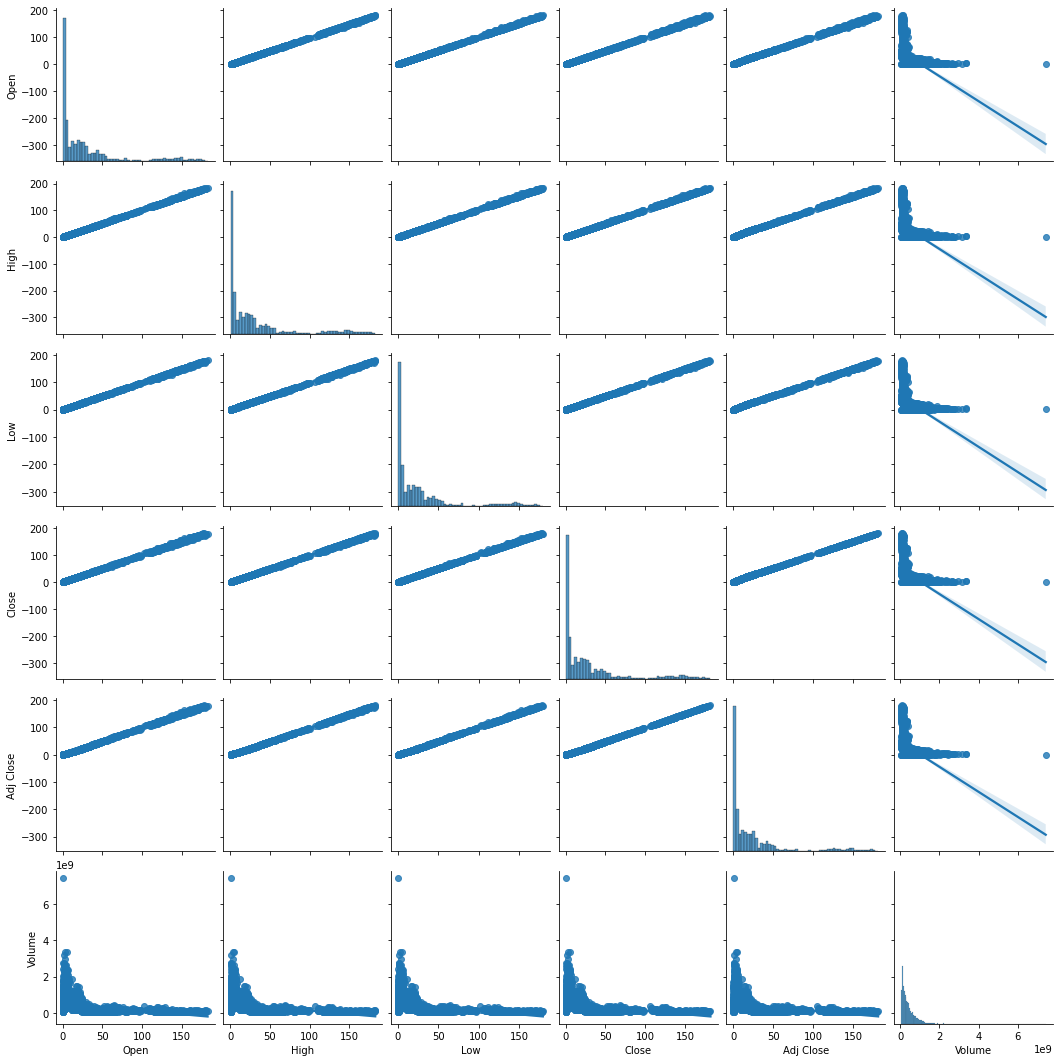

In [13]:
sb.pairplot(apple_data, kind='reg');

In [14]:
# Make of a copy of the dataset for the two different models

ls_data = apple_data.copy()
ph_data = apple_data.copy()

# Stock Prediction with LSTM

In [15]:
# Specify the predictor and target variables

x = ls_data[["Open", "High", "Low", "Volume"]]
y = ls_data["Close"]
x = x.to_numpy()
y = y.to_numpy()
y = y.reshape(-1, 1)

In [16]:
# Set the train and test size 

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=42)
print("xtrain", xtrain.shape)
print("ytrain", ytrain.shape)
print("xtest", xtest.shape)
print("ytest", ytest.shape)

xtrain (4595, 4)
ytrain (4595, 1)
xtest (1149, 4)
ytest (1149, 1)


In [17]:
# Now to apply LSTM

model = Sequential()
model.add(LSTM(128, return_sequences = True, input_shape = (xtrain.shape[1], 1)))
model.add(LSTM(64, return_sequences = False))
model.add(Dense(25))
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4, 128)            66560     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 25)                1625      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 117,619
Trainable params: 117,619
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Fit model on the data

model.compile(optimizer = "adam", loss = "mean_squared_error")
model.fit(xtrain, ytrain, batch_size = 1, epochs = 15)

Epoch 1/15
4595/4595 [==============================] - 30s 5ms/step - loss: 120.6886
Epoch 2/15
4595/4595 [==============================] - 25s 5ms/step - loss: 12.4614
Epoch 3/15
4595/4595 [==============================] - 25s 5ms/step - loss: 12.1836
Epoch 4/15
4595/4595 [==============================] - 24s 5ms/step - loss: 9.1462
Epoch 5/15
4595/4595 [==============================] - 24s 5ms/step - loss: 7.8261
Epoch 6/15
4595/4595 [==============================] - 25s 5ms/step - loss: 10.1291
Epoch 7/15
4595/4595 [==============================] - 25s 5ms/step - loss: 7.1701
Epoch 8/15
4595/4595 [==============================] - 24s 5ms/step - loss: 8.5922
Epoch 9/15
4595/4595 [==============================] - 25s 5ms/step - loss: 5.9719
Epoch 10/15
4595/4595 [==============================] - 25s 5ms/step - loss: 5.9486
Epoch 11/15
4595/4595 [==============================] - 25s 5ms/step - loss: 4.5771
Epoch 12/15
4595/4595 [==============================] - 25s 5ms/step

In [19]:
prediction = model.predict(xtest)

36/36 [==============================] - 2s 5ms/step


In [20]:
# Test the model on a sample data

#features = [Open, High, Low, Adj Close, Volume]
features = np.array([[177.089996, 180.419998, 177.070007, 74919600]])
model.predict(features)

1/1 [==============================] - 0s 86ms/step


array([[166.68341]], dtype=float32)

In [21]:
# Generate the error 

print("The mean squared error (MSE) = ", mean_squared_error(ytest, prediction))
print("The mean absolute error (MAE) = ", mean_absolute_error(ytest, prediction))
print("The mean squared log error (MSLE) = ", mean_squared_log_error(ytest, prediction))

The mean squared error (MSE) =  18.55894861243332
The mean absolute error (MAE) =  1.7455909874280502
The mean squared log error (MSLE) =  0.002197420114959094
